# barrier_cert

Synthesize a probabilistic barrier certificate to get a lower bound on the probability that a target set is reached. 
## Mathematics

Consider the polynomial dynamics

$$
x(t+1) = f(x(t), t, w),  \quad  w \sim \mathcal N(0, \Sigma)
$$
    
and the sets

$$  
X = \{x : g(x) \geq 0 \} \\
X_0 = \{x : g_0(x) \geq 0\} \\
X_1 = \{x : g_1(x) \geq 0\}
$$

We want to find a lower bound on the property that we reach $X_1$ given that we start in $X_0$ and remain in $X$ during the whole transition.

$$
p_{01} = \mathbb{P} \left[ x(T) \in X_1 \; \mid \; x(0) \in X_0, x(t) \in X \right]
$$

Consider a certificate $B(x, t)$ satisfying

\begin{align}
    B(x, t) &\geq 0        \quad & x \in X  \\
    B(x, 0) &\leq \gamma   \quad & x \in X_0     \\
    B(x, T) &\geq 1        \quad & x \not \in X_1, x \in X\\
    \mathbb{E} \left[ B(x(t+1), t+1)) \; \mid \; x(t) \right]  &\leq B(x(t), t) + c  \quad & x \in X
\end{align}

It obviously follows that with $B(t) = B(x(t), t)$ the last constraint implies $\mathbb{E} \left[ B(T) \right] < B(0) + cT$. Since $B$ is positive we can use Markov's inequality

$$
\mathbb{P} \left[ B(T) \leq 1 \right] = 1 - \mathbb{P} \left[ B(T) \geq 1 \right] \geq 1 - \mathbb{E} [B(T)] \geq 1 - (B(0) + cT)
$$

If $A \impliedby B$ and $C \implies D$, then $\mathbb{P}(A \mid C) \geq \mathbb{P}(B \mid D)$. From the constraints we have that
$$
    x(T) \in X_1 \impliedby B(T) \leq 1, \\
    x(0) \in X_0 \implies B(0) \leq \gamma.
$$
Therefore,
$$
p_{01} = \mathbb{P}\left[x(T) \in X_1 \; \mid \; x(0) \in X_0 \right] \geq \mathbb{P}\left[ B(T) \leq 1 \; \mid \; B(0) \leq \gamma \right] \geq 1 - (\gamma + cT).
$$

Thus we search for a barrier certificate that satisfies the conditions above while minimizing $\gamma + cT$.

In [1]:
from sympy.abc import x, y, w
import numpy as np

from posipoly.polynomial import Polynomial
from posipoly.polylintrans import PolyLinTrans
from posipoly.ppp import PPP

g  = Polynomial.from_sympy(1, [x,y])
g0 = Polynomial.from_sympy(0.25**2 - x**2 - y**2, [x,y])
g1 = Polynomial.from_sympy(0.5**2 - (x-1)**2 - y**2, [x,y])

# dynamics: 
#  x(t+1) = x(t) + 0.25 + w
#  y(t+1) = y(t)

ft_x = Polynomial.from_sympy(x + 0.25 + w, [x,y,w])
ft_y = Polynomial.from_sympy(y, [x,y,w])

T = 4
sigma = 0.1
tot_deg = 6

We synhesize a separate barrier for each discrete time step, i.e. $B(x,t) = B_t(x)$. Using the S procedure we can rewrite the problem above as

\begin{align}
    c + B_t(x) - \mathbb{E} [B_{t+1}(f(x, t, w)) ] - r_t(x) g(x)  & \geq 0, \qquad  t=0, ..., T-1 \\
    \gamma - B_0(x) - s_0(x) g_0(x)  & \geq 0, \\
    B_T(x) - 1 + s_1(x) g_1(x) - u(x)g(x)      & \geq 0, \\
    B_t(x) - v_t(x) g(x)             & \geq 0, \qquad  t=0, ..., T \\
    s_0(x), s_1(x), u(x) & \geq 0, \\
    r_t(x) & \geq 0,    \qquad  t=0, ..., T-1 \\
    v_t(x) & \geq 0,     \qquad  t=0, ..., T
\end{align}

Or by introducing additional variables $e_t. w_t$ and $q_0, q_1$

\begin{align}
    c + B_t(x) - \mathbb{E} [ B_{t+1}(f(x,t,w)) ] - r_t(x) g(x) - e_t(x) & = 0, \qquad     t=0, ..., T-1 \\
    \gamma - B_0(x) - s_0(x)g_0(x) - q_0(x) & = 0, \\
    B_T(x) + s_1(x)g_1(x) - u(x)g(x) - q_1(x) & = 1, \\
    B_t(x) - v_t(x) g(x) - w_t(x) & = 0,                       \qquad t=0, ..., T \\
    s_0(x), s_1(x), q_0(x), q_1(x), u(x) & \geq 0, \\
    r_t(x), e_t(x) & \geq 0,    \qquad  t=0, ..., T-1 \\
    v_t(x), w_t(x) & \geq 0,     \qquad  t=0, ..., T
\end{align}

In [2]:
deg_B = tot_deg   # need to subtract if deg f larger than 1
deg_s0 = tot_deg-g0.d
deg_s1 = tot_deg-g1.d
deg_u = tot_deg-g.d

prog = PPP()

prog.add_var('c', 1, 0, 'coef')  # scalar variable = polynomial in 1 var degree 0
prog.add_var('gamma', 1, 0, 'coef')  # scalar variable

for t in range(T+1):
    prog.add_var('B{}'.format(t), 2, deg_B, 'coef')
    prog.add_var('v{}'.format(t), 2, deg_u, 'pp')
    prog.add_var('w{}'.format(t), 2, tot_deg, 'pp')

for t in range(T):
    prog.add_var('r{}'.format(t), 2, deg_u, 'pp')
    prog.add_var('e{}'.format(t), 2, tot_deg, 'pp')

prog.add_var('s0', 2, deg_s0, 'pp')
prog.add_var('s1', 2, deg_s1, 'pp')
prog.add_var('q0', 2, tot_deg, 'pp')
prog.add_var('q1', 2, tot_deg, 'pp')
prog.add_var('u', 2, deg_u, 'pp')

Prepare the transformations

In [3]:
# Identity for scalars to tot_deg
T1 = PolyLinTrans.eye(n0=1, n1=2, d0=0, d1=tot_deg)

# Identity for scalars to scalar
T10 = PolyLinTrans.eye(n0=1, n1=1, d0=0, d1=0)

# B(x,y) -> E_w[ B(fx(x,y,w), fy(x,y,w)) ]
TBp = PolyLinTrans.gaussian_expectation(n0=3, d0=deg_B, xi=2, sigma=sigma) \
      * PolyLinTrans.composition(n0=2, d0=deg_B, g_list=[ft_x, ft_y])

# Identity for B
TB  = PolyLinTrans.eye(n0=2, n1=2, d0=deg_B)     

# Multiplication with g, g0, g1
Tg  = PolyLinTrans.mul_pol(n=2, d=deg_u, poly=g)
Tg0 = PolyLinTrans.mul_pol(n=2, d=deg_s0, poly=g0)
Tg1 = PolyLinTrans.mul_pol(n=2, d=deg_s1, poly=g1)

# Identity for free variables
Tfr = PolyLinTrans.eye(n0=2, n1=2, d0=tot_deg)

These are the constraints in algebra form

    T1.c + TB.Bt - Tbp.B(t+1) - Tg.rt -  Tfr.et = 0   t=0, ..., T-1    (1)
    T1.gamma - TB.B0 - Tg0.s0 - Tfr.q0 = 0                             (2)
    TB.BT + Tg1.s1 - Tg.u - Tfr.q1 = 1                                 (3)
    TB.Bt - Tg.vt - Tfr.wt = 0                        t=0, ..., T      (4)

In [4]:
# add (1)
for t in range(T):
    Aop = {'c': T1,
           'B{}'.format(t): TB, 
           'B{}'.format(t+1): -TBp,
           'r{}'.format(t): -Tg,
           'e{}'.format(t): -Tfr}
    prog.add_row(Aop, np.zeros(T1.numcon), 'eq')

# add (2)
prog.add_row({'gamma': T1, 'B0': -TB, 's0': -Tg0, 'q0': -Tfr}, np.zeros(T1.numcon), 'eq')
    
# add (3)
prog.add_row({'B{}'.format(T): TB, 's1': Tg1, 'u': -Tg, 'q1': -Tfr}, [1] + [0] * (T1.numcon-1), 'eq')

# add (4)
for t in range(T+1):
    Aop = {'B{}'.format(t): TB, 
           'v{}'.format(t): -Tg,
           'w{}'.format(t): -Tfr}
    prog.add_row(Aop, np.zeros(T1.numcon), 'eq')
    
# add inequality: gamma <= 1  (to exclude large solutions)
prog.add_row({'gamma': T10}, [1], 'iq')

# add objective
prog.set_objective({'c': [T], 'gamma': [1]})

Time to solve it!

In [5]:
sol, status = prog.solve('psd')

c = prog.get_poly('c').evaluate(0)
gamma = prog.get_poly('gamma').evaluate(0)

lb = 1-(gamma+c*T)

print('got c={:.2f} and gamma={:.2f}'.format(c, gamma))
print('lower bound is {:.2f}'.format(lb))

got c=-0.14 and gamma=0.95
lower bound is 0.62


From the certificates we can now plot a lower bound on the probability that the target set is reached. From the proof above it follows that

$$
\mathbb{P}(x(T) \in X_1 \mid x(t) = x) \geq 1 - (c(T-t) + B(x)).
$$

<IPython.core.display.Javascript object>


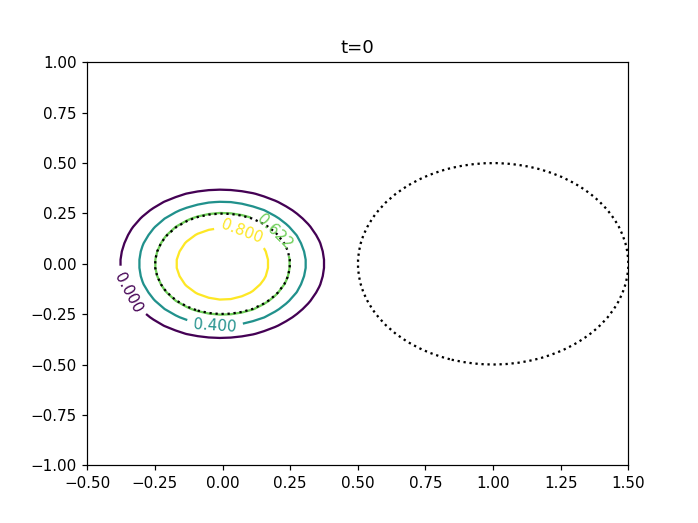

<IPython.core.display.Javascript object>


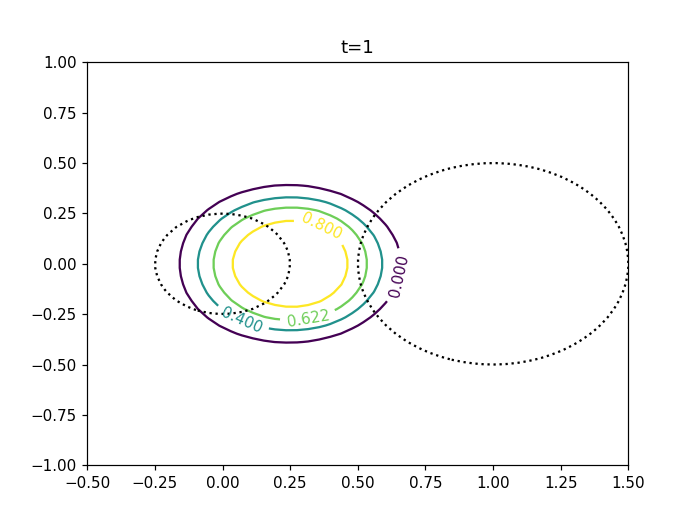

<IPython.core.display.Javascript object>


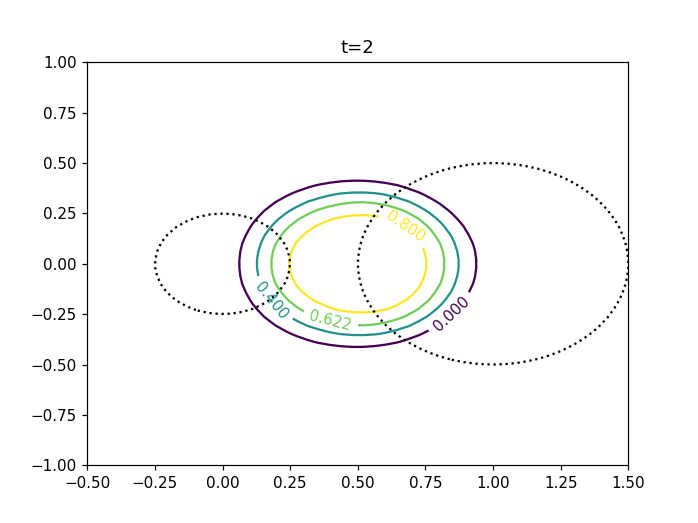

<IPython.core.display.Javascript object>


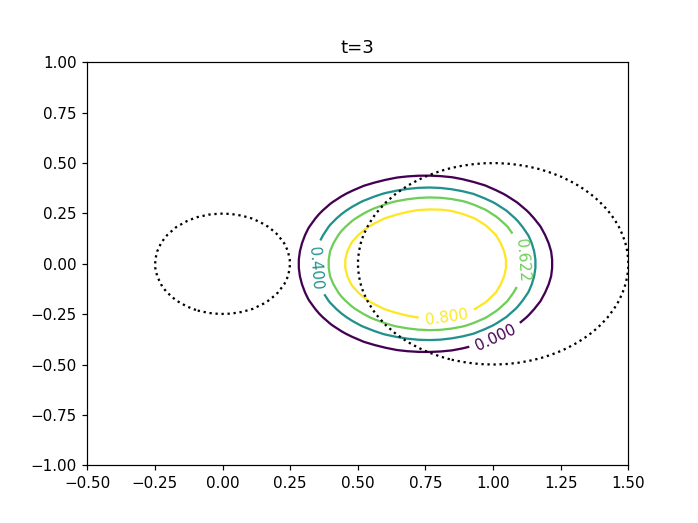

<IPython.core.display.Javascript object>


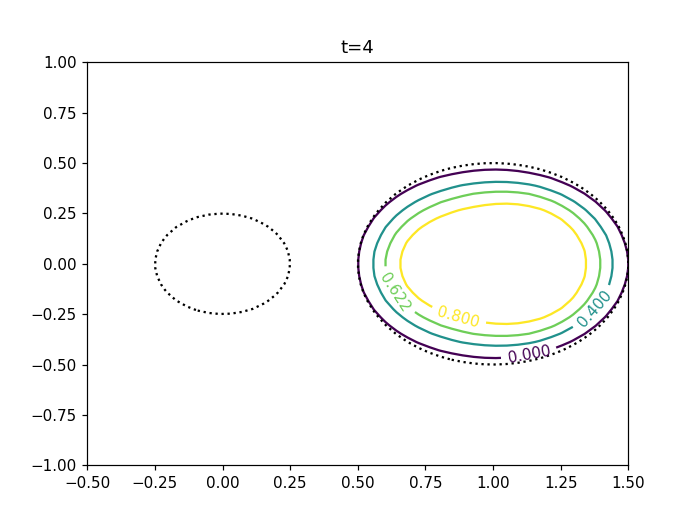

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

xx = np.linspace(-0.5, 1.5, 50)
yy = np.linspace(-1, 1, 50)

XX, YY = np.meshgrid(xx, yy)

g0_val = np.vectorize(g0.evaluate)(XX, YY)
g1_val = np.vectorize(g1.evaluate)(XX, YY)

levels = sorted([0, 0.4, 0.8, lb])

for t in [0, 1, 2, 3, 4]:
    Bt = prog.get_poly('B{}'.format(t))
    Bt_val = np.vectorize(Bt.evaluate)(XX, YY)
    proba_min = 1 - (Bt_val + c * (T-t))
    plt.figure()
    CS = plt.contour(XX, YY, proba_min, levels=levels)
    plt.clabel(CS, inline=1, fontsize=10)
    
    plt.contour(XX, YY, g0_val, levels=[0], colors='black', linestyles='dotted')
    plt.contour(XX, YY, g1_val, levels=[0], colors='black', linestyles='dotted')
    plt.title('t={}'.format(t))

plt.show()